In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
pd.set_option('display.max.colwidth', 130)

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm 
fm._rebuild() 
%matplotlib inline


import feedparser
from bs4 import BeautifulSoup as bs
import urllib
import urllib.request as req
import requests

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

from konlpy.tag import Kkma, Okt, Komoran
okt = Okt()
from konlpy.utils import pprint

from collections import Counter
from datetime import datetime

In [3]:
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

import matplotlib

import matplotlib.font_manager as fm 
fm._rebuild() 

# 그래프에서 한글표현을 위해 폰트를 설치합니다.
%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

from plotnine import *
import plotnine

import warnings
warnings.filterwarnings("ignore")

In [4]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import string

from gensim.models import Word2Vec

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

    

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
# 키워드: 춘천, 기간: 1일
url = "https://search.naver.com/search.naver?&where=news&query=춘천&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=&pd=4&ds=&de=&docid=&nso=so:r,p:1d,a:all&mynews=0&cluster_rank=38&start=1&refresh_start=0"

raw = requests.get(url)
html = raw.content
soup = bs(html,'html.parser')

In [6]:
last = False
page_num = 1
href_list = []
TitDesc_list = []
title_list = []
while last == False:
  raw_url = requests.get("https://search.naver.com/search.naver?&where=news&query=춘천&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=&pd=4&ds=&de=&docid=&nso=so:r,p:1d,a:all&mynews=0&cluster_rank=38&start="+str(page_num)+"&refresh_start=0")
  html = raw_url.content
  soup = bs(html, 'html.parser')

  # 주소 가져오기
  ul = soup.find('ul', {'class' : 'type01'})
  li_list = ul.findAll('li')

  # 검색 시 연관 뉴스는 제외시킴
  for li in li_list:
    try:
      href_list.append(li.dl.dt.a['href'])   # 주소 추가

      d_list = li.findAll('dd')    # 자식 노드 dd가 두 개인데 두 번째 노드에 description이 들어가있으므로 전부 불러온 후 인덱싱할 것임

      title = li.dl.dt.a['title']
      description = d_list[1].text    # 자식 노드 dd의 두 번째에 들어가 있는 description을 text로 불러옴
      title_list.append(title)
      TitDesc_list.append( title + ' ' + description)
    except AttributeError:
      pass

  # 마지막 페이지 주소 확인 (다음페이지 버튼이 없으면 종료페이지로 간주)
  page = soup.find('div', {'class':'paging'})
  page_a_list = page.findAll('a')
  if '다음페이지' in str(page_a_list[-1]):
    page_num += 10
  else:
    last = True

len(TitDesc_list)

313

In [7]:
TitDesc_okt = []

for item in TitDesc_list:
  item_nouns = ' '.join(okt.nouns(item))
  TitDesc_okt.append(item_nouns)

  tfidf_vectorizer = TfidfVectorizer()
  tfidf_matrix_okt = tfidf_vectorizer.fit_transform(TitDesc_okt)
TitDesc_okt[:3]
#Vectorization

['춘천시 경로당 운영 재개 강원 춘천시 폭염 대비 무더위 터 활용 위해 경로당 운영 재개 준비 춘천 내 경로당 코로나 발생 지난 운영 잠정 중단 여름철 더위 취약 어르신',
 '춘천시 하절 기 장마철 환경오염 행위 특별 감시 실시 춘천 시청 전경 춘천시 하절 기 장마철 환경오염 행위 특별 감시 를 실시 하절 기 장마철 집중호우 오염 물질 수역 다량 유입 가능성 시기 이 시기',
 '춘천시 집중호우 시 오염 물질 배출 사전 차단 강원 춘천시 집중호우 시 오염 물질 배출 행위 사전 차단 시 이번 달 시 특별 감시 통해 춘천 자연환경 오염 것 말 신아일보 춘천']

In [11]:
doc_df = pd.DataFrame(data=TitDesc_okt)
doc_df.columns = ["title + article"]
doc_df['title'] = 0
doc_df['num']=0
for i in range(len(doc_df)):
  doc_df.iloc[i, 2] = i
  doc_df.iloc[i, 1] = title_list[i]
doc_df.head()
topic_df = doc_df

# Elbow Method

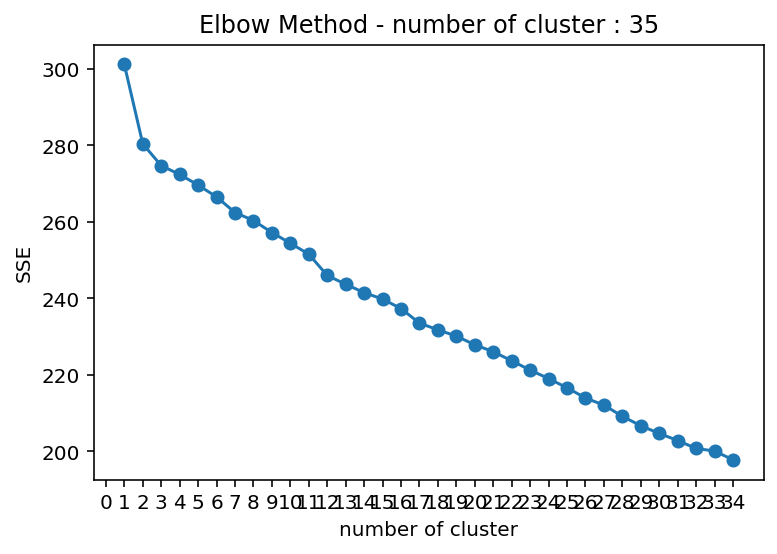

In [12]:
x = normalize(tfidf_matrix_okt)
# L2 정규화

def elbow(normalizedData, Clusters):
  sse = []
  for i in range(1,Clusters):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(normalizedData)
    sse.append(kmeans.inertia_)

  plt.plot(range(1,Clusters), sse, marker='o')
  plt.xlabel('number of cluster')
  plt.xticks(np.arange(0,Clusters,1))
  plt.ylabel('SSE')
  plt.title('Elbow Method - number of cluster : '+str(Clusters))
  plt.show()
elbow(x, 35)

# Tokenize

In [13]:
tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize)
feature_vect = tfidf_vect.fit_transform(topic_df['title + article'])

# Clustering

In [14]:
clusters_num = 11

km_cluster = KMeans(n_clusters=clusters_num, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

In [17]:
topic_df['cluster_label'] = cluster_label
topic_df.head()

for i in range(clusters_num):
  print('<<Clustering Label {0}>>'.format(i)+'\n')
  print(topic_df.loc[topic_df['cluster_label']==i])

<<Clustering Label 0>>

                                                                                                                       title + article  ... cluster_label
39                                    포토 뉴스 한기호 춘천 철원 화천 양구 의원 통합 강원도 위원장 선출 미래 통합 강원도 도당 회의실 운영 위원회 한기호 춘천 철원 화천 양구 국회의원 신임 도당 위원장 선출  ...             0
72                       통합 도당 위원장 한기호 추대 한기호 춘천 철원 화천 양구 사진 국회의원 미래 통합 강원도 위원장 통합 도당 오전 도 당사 운영 위원회 개최 도당 위원장 선출 건 심의 의결 도당 위원장 후보 접수  ...             0
79                           법무부 제 교정 대상 시상식 거행 교정 참여 인사 여 년 사랑 봉사 정신 수형 교정 교화 헌신 수형 위 종교 행사 주관 등 신앙 통해 삶 살 수 계기 마련 준 한길 용 교정 위원 춘천교도소  ...             0
84                               우회 노자 도덕경 휘호집 발간 김 선배 이면우 전 춘천교대 총장 권영중 전 강원 총장 순 전 춘천교대 동문회 비롯 여명 회원 틈틈이 편의 작품 권 책 수십 년 예술가 경지 회원 초보  ...             0
105                      통합 도당 위원장 한기호 추대 한기호 춘천 철원 화천 양구 사진 국회의원 미래 통합 강원도 위원장 통합 도당 오전 도 당사 운영 위원회 개최 도당 위원장 선출 건 심의 의결 도당 위원장 후보 접수  ...             0
116                          법무부 제 교정 대상 시상식 거행 교정 참

In [19]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape : ', cluster_centers.shape)
print(cluster_centers)

cluster_centers shape :  (11, 2379)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00212289 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.0166098  0.         0.        ]
 [0.         0.         0.00564682 ... 0.         0.         0.01363597]]


# Topic Keyword Top10

In [20]:
# 군집별 top n 핵심단어, 그 단어의 중심 위치 상대값, 대상 제목들을 반환함. 
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
    cluster_details = {}
    
    # cluster_centers array 의 값이 큰 순으로 정렬된 index 값을 반환
    # 군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함.  
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    #개별 군집별로 iteration하면서 핵심단어, 그 단어의 중심 위치 상대값, 대상 제목 입력
    for cluster_num in range(clusters_num):
        # 개별 군집별 정보를 담을 데이터 초기화. 
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # cluster_centers_.argsort()[:,::-1] 로 구한 index 를 이용하여 top n 피처 단어를 구함. 
        top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [ feature_names[ind] for ind in top_feature_indexes ]
        
        # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함 
        top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()
        
        # cluster_details 딕셔너리 객체에 개별 군집별 핵심 단어와 중심위치 상대값, 그리고 해당 파일명 입력
        cluster_details[cluster_num]['top_features'] = top_features
        cluster_details[cluster_num]['top_features_value'] = top_feature_values
        filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['title']
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['title'] = filenames
        
    return cluster_details

In [21]:
def print_cluster_details(cluster_details):    
    for cluster_num, cluster_detail in cluster_details.items():
        print('####### Cluster {0}'.format(cluster_num))
        print('Top features:', cluster_detail['top_features'])
        print('Title :',cluster_detail['title'][:7])
        print('==================================================')

In [22]:
feature_names = tfidf_vect.get_feature_names()

cluster_details = get_cluster_details(cluster_model=km_cluster, cluster_data=topic_df,\
                                  feature_names=feature_names, clusters_num=clusters_num, top_n_features=10 )
print_cluster_details(cluster_details)

####### Cluster 0
Top features: ['교정', '위원장', '도당', '위원', '통합', '한기호', '민주', '회원', '전', '수형']
Title : ['[포토뉴스]한기호(춘천.철원.화천.양구 을) 의원 통합당 강원도당 위원장 선출', '통합당 도당위원장 한기호 추대', '법무부, 제38회 교정대상 시상식 거행', "소소서우회 '노자 도덕경 휘호집' 발간", '통합당 도당위원장 한기호 추대', '법무부, 제38회 교정대상 시상식 거행', "소소서우회 '노자 도덕경 휘호집' 발간"]
####### Cluster 1
Top features: ['명', '씨', '채', '징역', '혐의', '아파트', '예식장', '등', '집', '기소']
Title : ['[춘천]춘천 인구 4개월 연속 줄었다', '이달말부터 춘천 소양2교 안전진단…차량통제 없어', '[춘천]소양2교 정밀 안전진단 추진', '[내일날씨] 오후 내륙 곳곳 비 소식…서울 낮 최고 30도', '[공직자의 집]③ 강원도 고위공직자 31%, 집 2채 이상 보유', '[공직자의 집]③ 다주택자 31%…“집? 두 채는 있어야”', '강원대 ‘코로나 극복 장학금’ 부모 실직·폐업 학생 146명에 지급']
####### Cluster 2
Top features: ['도', '강릉', '기온', '대전', '서울', '대구', '부산', '인천', '제주', '광주']
Title : ['전국에 비 소식..경남해안·제주 200㎜ 이상', '전국 곳곳 흐리고 장대비…제주·전남 호우경보', '[오늘 날씨] 전국 장맛비…제주 시작 오전9시 전역 확산', '[오늘날씨] 전국 오전 비…오후에 남부부터 그쳐', '[내일 날씨] 전국 장맛비…제주 돌풍동반 시간당 최대 70㎜ 물폭탄', '저녁부터 장맛비 북상…내일 오전엔 전국에 비', '[주말날씨] 주말 전국 흐린 날씨…월요일 전국에 장맛비']
####### Cluster 3
Top features: ['구봉산', '투썸플레이스', '점', '

# Word2Vec Similarity between Words

## Create Word2Vec Word Vocabulary

In [72]:
# 토큰화 된 문장 리스트를 단어별로 split한 후 2차원 리스트로 저장
WordVoca_list = []
for item in TitDesc_okt:
    WordVoca_list.append(item.split(' '))

# split된 2차원 리스트 중에서 한 글자짜리 단어들을 모두 제외시키고 WordVoca 리스트 생성
# Word2Vec 모델 학습 데이터로 활용됨
WordVoca = []
for i in range(len(WordVoca_list)):
    element = []
    for j in range(len(WordVoca_list[i])):
        if len(WordVoca_list[i][j]) > 1:
            element.append(WordVoca_list[i][j])
    WordVoca.append(element)

In [43]:
#model = Word2Vec(sentences=WordVoca_list, size=100, window=5, min_count=5, workers=4, sg=1)
#model_result = model.most_similar(positive=['경로당'], topn=10)
#model_result

In [91]:
def WordSimilarity(word, count):
    model = Word2Vec(sentences=WordVoca, size=100, window=5, min_count=5, workers=4, sg=1)
    model_result = model.most_similar(positive=[word], topn=count)

    Similarity_df = pd.DataFrame(model_result, columns=[word,'Similarity'])
    print('{0}과 유사한 단어 Top {1} :'.format(word, count))
    print(Similarity_df)

In [92]:
WordSimilarity('구봉산', 10)

구봉산과 유사한 단어 Top 10 :
      구봉산  Similarity
0      자락    0.999305
1      투썸    0.999233
2      동쪽    0.999212
3      병풍    0.999140
4      데크    0.998826
5      위치    0.998822
6      전경    0.998625
7     스카이    0.998606
8  투썸플레이스    0.998591
9      훤히    0.998381
